<h1>CONVOLUTIONAL NEURAL NETWORK APPLICATION</h1>
<h4>Deep Learning applied on MNIST</h4>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Import the MNIST dataset using TensorFlow built-in feature</h3>


In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

The features data are between 0 and 255, and we will normalize this to improve optimization performance.

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

We need to convert the data into a one-hot encoded vector. In contrast to Binary representation, the labels will be presented in a way that to represent a number N, the  𝑁𝑡ℎ bit is 1 while the the other bits are 0.

In [4]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


Initial parameters <br>
Create general parameters for the model

In [5]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

<h3>Converting images of the data set to tensors</h3>
<br>
The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the batch number of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.

In [6]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [7]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

<h3>Convolutional Layer 1</h3>


<h4>Defining kernel weight and bias</h4>
We define a kernel here. The Size of the filter/kernel is 5x5;  Input channels is 1 (grayscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>


In [8]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width: 800px; height: 400px;" alt="HTML5 Icon">

</h4>Convolve with weight tensor and add biases.</h4>

To create convolutional layer, we use <b>tf.nn.conv2d</b>. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:
- tensor of shape [batch, in_height, in_width, in_channels]. x of shape [batch_size,28 ,28, 1]
- a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]. W is of size [5, 5, 1, 32]
- stride which is  [1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. [1, 2, 2, 1]
    
    
Process:
- Change the filter to a 2-D matrix with shape [5\*5\*1,32]
- Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
- For each batch, right-multiplies the filter matrix and the image vector.

Output:
- A `Tensor` (a 2-D convolution) of size tf.Tensor 'add_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 [28x28] images. Here 32 is considered as volume/depth of the output image.


In [9]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

<h4>Apply the ReLU activation Function</h4>
In this step, we just go through all outputs convolution layer, <b>convolve1</b>, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.<br> Let f(x) is a ReLU activation function $f(x) = max(0,x)$.


In [10]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

<h4>Apply the max pooling</h4>
<b>max pooling</b> is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region. 

Lets use <b>tf.nn.max_pool</b> function to perform max pooling. 
<b>Kernel size:</b> 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)  
<b>Strides:</b> dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 



In [11]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

<h3>Convolutional Layer 2</h3>
<h4>Weights and Biases of kernels</h4>
<br>
We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5 (25 pixels) 
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps) 
- 64 output feature maps  

<b>Notice:</b> here, the input image is [14x14x32], the filter is [5x5x32], we use 64 filters of size [5x5x32], and the output of the convolutional layer would be 64 convolved image, [14x14x64].

<b>Notice:</b> the convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1], that is, the convolution is functioning on volume.


In [12]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

<h4>Convolve image with weight tensor and add biases.</h4>


In [13]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

<h4>Apply the ReLU activation Function</h4>


In [14]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

<h4>Apply the max pooling</h4>


In [15]:
def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

<h3>Fully Connected Layer</h3>



You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]


<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 


<h4>Flattening Second Layer</h4>


In [16]:
def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

<h4>Weights and Biases between layer 2 and 3</h4>

Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer


In [17]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

<h4>Matrix Multiplication (applying weights and biases)</h4>


In [18]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

<h4>Apply the ReLU activation Function</h4>

In [19]:
def h_fc1(x): return tf.nn.relu(fcl(x))

<h4>Dropout Layer, Optional phase for reducing overfitting</h4>


It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes. This can be very useful for very large neural networks to prevent overfitting.

In [20]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

<h4>Readout Layer (Softmax Layer)</h4>


<h4>Readout Layer (Softmax Layer)</h4>
<h4>Weights and Biases</h4>

In last layer, CNN takes the high-level filtered images and translate them into votes using softmax.
Input channels: 1024 (neurons from the 3rd Layer); 10 output features


In [21]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

<h4>Matrix Multiplication (applying weights and biases)</h4>


In [22]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

<h4>Apply the Softmax activation Function</h4>
<b>softmax</b> allows us to interpret the outputs of <b>fcl4</b> as probabilities. So, <b>y_conv</b> is a tensor of probabilities.


In [23]:
def y_CNN(x): return tf.nn.softmax(fc(x))

<a id="ref8"></a>
<h2>Define functions and train the model</h2>
<br>
<h4>Define the loss function</h4>

We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use <b>cross entropy</b> to see how bad our CNN is working - to measure the error at a softmax layer.

The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified. You can run it (first change the cell type to <b>code</b> in the toolbar) to see how cross entropy changes.


In [24]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

<h4>Define the optimizer</h4>

It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: GradientDescent or Adagrad. 


In [25]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Following the convention of our first example, we will use GradientTape to define a model.

In [26]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()


<h4>Define prediction</h4>
Do you want to know how many of the cases in a mini-batch has been classified correctly? lets count them.


In [27]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

<h4>Define accuracy</h4>
It makes more sense to report accuracy using average of correct cases.

In [29]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

<h4>Run session, train</h4>

In [30]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) )  

epoch  0 batch 50 loss: 128.91978 accuracy 0.44
epoch  0 batch 100 loss: 50.301483 accuracy 0.66
epoch  0 batch 150 loss: 35.88539 accuracy 0.62
epoch  0 batch 200 loss: 27.9567 accuracy 0.92
epoch  0 batch 250 loss: 23.576477 accuracy 0.72
epoch  0 batch 300 loss: 21.448395 accuracy 0.8
epoch  0 batch 350 loss: 23.457935 accuracy 0.84
epoch  0 batch 400 loss: 18.495401 accuracy 0.9
epoch  0 batch 450 loss: 24.163132 accuracy 0.78
epoch  0 batch 500 loss: 20.495739 accuracy 0.92
epoch  0 batch 550 loss: 18.131 accuracy 0.94
epoch  0 batch 600 loss: 16.950861 accuracy 0.88
epoch  0 batch 650 loss: 19.619139 accuracy 0.78
epoch  0 batch 700 loss: 8.0180855 accuracy 0.96
epoch  0 batch 750 loss: 19.45737 accuracy 0.86
epoch  0 batch 800 loss: 15.88221 accuracy 0.84
epoch  0 batch 850 loss: 24.769873 accuracy 0.92
epoch  0 batch 900 loss: 16.112991 accuracy 0.94
epoch  0 batch 950 loss: 17.008003 accuracy 0.88
epoch  0 batch 1000 loss: 15.322015 accuracy 0.94
epoch  0 batch 1050 loss: 8.06

In [31]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))            

batch 100 accuracy 0.96
batch 200 accuracy 0.96
batch 300 accuracy 0.94
batch 400 accuracy 0.94
batch 500 accuracy 0.92
batch 600 accuracy 0.9
batch 700 accuracy 0.96
batch 800 accuracy 0.96
batch 900 accuracy 0.96
batch 1000 accuracy 0.98
batch 1100 accuracy 0.92
batch 1200 accuracy 0.98
accuracy of entire set 0.9361


FileUpload(value={}, description='Upload')

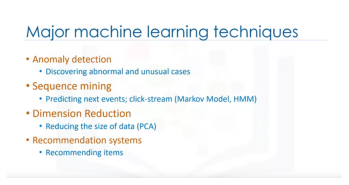

AttributeError: read

In [56]:
import matplotlib.pyplot as plt
from IPython.display import display
import io
import tensorflow as tf
from PIL import Image
import ipywidgets as widgets
import numpy as np

# Assuming Y_CNN is a trained CNN model
# Define Y_CNN or replace it with your trained model

def process_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path)
    
    # Convert the image to grayscale
    img = img.convert('L')
    
    # Resize the image to 28x28 pixels (MNIST dataset's input size)
    img = img.resize((28, 28))
    
    # Normalize the pixel values to be between 0 and 1
    img_array = np.asarray(img) / 255.0
    
    # Reshape the image to match the expected input shape for MNIST (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)
    
    return img_array

def predict_image(img):
    processed_img = process_image(img)
    prediction = y_CNN(processed_img)  # Assuming Y_CNN is a model with a 'predict' method
    return np.argmax(prediction)

def handle_upload(change):
    img = Image.open(io.BytesIO(upload.data[-1]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    prediction = predict_image(img)
    print('Predicted digit:', prediction)

upload = widgets.FileUpload()
display(upload)
upload.observe(handle_upload, names='data')
image_path = 'path_to_your_image.jpg'  # Replace with the actual path to your image
processed_image = preprocess_image(image_path)